# K.c Kula Computational Methods in the Sciences Final Project

The following is a final project for my Computational Methods in the Sciences course. Project guiding question: Can neural networks predict a speaker's gender(as defined in the dataset) using Mel Spectrograms and neural networks? Does the language impact classification accuracy?


## Brief Summary
This project found that using a neural network on 2 second clips produces slightly higher than average accuracy on the test data. The German data preformed slightly better, although future improvements could include: longer clips, different method(CNN), including "other" voices, and/or multiple speakers in one clip.

# Sources

## Overall
Data are from  Mozilla Common Voice Corpus 7.0 English and German Files


This project relied heavily on the following 2 sources. This is also denoted when used.
*  https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
*   Chat GPT

I also talked to members of LingoPal, a startup specializing in real-time audio and video translation.

## Imports:


*   https://favtutor.com/articles/pandas-read-tsv/








## Preprocessing Labels
*   https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
*   https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
*   https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
*   Chat GPT
*   https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html





##Pre-Preprocessing Files


*   https://pandas.pydata.org/docs/user_guide/merging.html
*   Chat GPT




## Preprocessing Files


*   Chat GPT
*   https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
*   https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
*  https://www.geeksforgeeks.org/working-with-wav-files-in-python-using-pydub/








## German and English File Processing

*   Chat GPT
*   https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
* https://stackoverflow.com/questions/75979632/pytorchs-nn-bcewithlogitsloss-behaves-totaly-differently-than-nn-bceloss



# Imports

In [ ]:

import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%pip install pydub
from pydub import AudioSegment
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import zipfile



# Google Drive imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Reads in training and testing files for both languages
#Imports tsv file from Drive  # https://favtutor.com/articles/pandas-read-tsv/
df_de_train = pd.read_csv('de/train.tsv', sep='\t')
df_de_test = pd.read_csv('de/test.tsv', sep='\t')
df_en_train = pd.read_csv('en/train.tsv', sep='\t')
df_en_test = pd.read_csv('en/test.tsv', sep='\t')

# Path to dataset
path_to_datasets = 'path_to_dataset'




Mounted at /content/drive


replace_mp3_on_set is a function that changes end of file name in dataframe to .wav from .mp3. We need to do this, as we expect our audio files will be .wav. This function takes in a filename and converts the label to end in .wav(ex. file 123456.mp3 and turns it into 123456.wav). This does not change the actual file type, as that will be in the preprocessing audio section.

In [ ]:
#Replaces the file name to end in .wav in the table so we can accuratly use the file name when it is time to compare
#Used GPT for the idea of how to replace in a dataframe.
def replace_mp3_on_set(filename):
  filename_trim = filename[:-3] #Takes out the .mp3
  filename_csv_end = filename_trim + "wav" #Replaces it with .wav
  return filename_csv_end #Returns the new file name in our table

Below is the code that applied the above function to the dataframes containing the labels. The dataframe is then trimmed so only columns path and gender remain (path = filename, gender = voice identified as male, female, na, or other). Next, the data are included only if the voices are categorized as male or female(excludes na and other). Finally, the head of the dataframes are printed to confirm the changes appear.

In [ ]:
#German train replacement
df_de_train['path'] = df_de_train['path'].apply(replace_mp3_on_set) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
trimmed_df_de_train = df_de_train[['path', 'gender']] #https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
trimmed_df_de_train_gender = trimmed_df_de_train[trimmed_df_de_train['gender'].isin(['male', 'female'])] # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html

#German test replacement
df_de_test['path'] = df_de_test['path'].apply(replace_mp3_on_set) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
trimmed_df_de_test = df_de_test[['path', 'gender']] #https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
trimmed_df_de_test_gender = trimmed_df_de_test[trimmed_df_de_test['gender'].isin(['male', 'female'])] # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html

#English train replacement
df_en_train['path'] = df_en_train['path'].apply(replace_mp3_on_set) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
trimmed_df_en_train = df_en_train[['path', 'gender']] #https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
trimmed_df_en_train_gender = trimmed_df_en_train[trimmed_df_en_train['gender'].isin(['male', 'female'])] # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html

#English test replacement
df_en_test['path'] = df_en_test['path'].apply(replace_mp3_on_set) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
trimmed_df_en_test = df_en_test[['path', 'gender']] #https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
trimmed_df_en_test_gender = trimmed_df_en_test[trimmed_df_en_test['gender'].isin(['male', 'female'])] # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html

#Prints the first few rows of the DataFrame to check changes
print(trimmed_df_de_train_gender.head())
print(trimmed_df_de_test_gender.head())
print(trimmed_df_en_train_gender.head())
print(trimmed_df_en_test_gender.head())

                           path gender
0  common_voice_de_22662923.wav   male
1  common_voice_de_22662924.wav   male
2  common_voice_de_22662926.wav   male
3  common_voice_de_22662929.wav   male
4  common_voice_de_22662930.wav   male
                            path  gender
6   common_voice_de_22072929.wav    male
8   common_voice_de_23931307.wav    male
12  common_voice_de_22012406.wav    male
21  common_voice_de_22121127.wav  female
91  common_voice_de_21956124.wav    male
                           path gender
0  common_voice_en_22107292.wav   male
1  common_voice_en_22107294.wav   male
2  common_voice_en_22107295.wav   male
3  common_voice_en_22107296.wav   male
4  common_voice_en_22107308.wav   male
                            path  gender
3   common_voice_en_21943181.wav    male
20  common_voice_en_22302952.wav    male
23  common_voice_en_22305996.wav    male
24  common_voice_en_22140642.wav  female
30  common_voice_en_22159151.wav    male


Unfortunatly, the data are extremely imbalanced. To combat this, I undersampled the males. I also undersampled all of the training and test sets to limit the number of files I had to process. To do this, I initially found the counts of the German and English training and test sets by gender and then chose to have 200 samples per gender in both language's training sets and 40 samples per gender in the test sets.

In [ ]:
#Balanced datasets so male samples dont overpower female samples
#Used GPT to randomly sample from the train and test

def balance_male_female_train(df): #This handles the train data
    # Filters rows for males and females
    males = df[df['gender'] == 'male']
    females = df[df['gender'] == 'female']

    # Get the smaller count. Likely female, but uses min to confirm this.
    min_count = min(len(males), len(females))

    # Balance both genders by sampling. To limit the files to process, if the minimum for the genders is greater than 200, only 200 samples are used to limit files processed.
    if min_count > 200:
      min_count = 200
    balanced_males = males.sample(n=min_count, random_state=12) #Randomly selects n number of files to be used where n = min_count(200)
    balanced_females = females.sample(n=min_count, random_state=12)

    # Combines balanced datasets to return the full training set.
    balanced_df = pd.concat([balanced_males, balanced_females])
    return balanced_df

def balance_male_female_test(df): #Same as above only with test set, using 40 samples
    # Filter rows for males and females
    males = df[df['gender'] == 'male']
    females = df[df['gender'] == 'female']

    # Get the smaller count
    min_count = min(len(males), len(females))


    if min_count > 40:
      min_count = 40
    balanced_males = males.sample(n=min_count, random_state=42)
    balanced_females = females.sample(n=min_count, random_state=42)

    # Combines balanced datasets to return the full testing set.
    balanced_df = pd.concat([balanced_males, balanced_females])
    return balanced_df


Below applied the functions above and prints the results.

In [ ]:

# Apply the function to each dataset
balanced_de_train = balance_male_female_train(trimmed_df_de_train_gender)
balanced_de_test = balance_male_female_test(trimmed_df_de_test_gender)
balanced_en_train = balance_male_female_train(trimmed_df_en_train_gender)
balanced_en_test = balance_male_female_test(trimmed_df_en_test_gender)


# Print to confirm that the gender counts accross languages are consistant. #Used gpt for help with creating new line and counting items easily
print("Balanced German Train Gender Counts:")
print(balanced_de_train['gender'].value_counts()) #https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html

print("\nBalanced German Test Gender Counts:") #\n creates new line.
print(balanced_de_test['gender'].value_counts())

print("\nBalanced English Train Gender Counts:")
print(balanced_en_train['gender'].value_counts())

print("\nBalanced English Test Gender Counts:")
print(balanced_en_test['gender'].value_counts())

Balanced German Train Gender Counts:
gender
male      200
female    200
Name: count, dtype: int64

Balanced German Test Gender Counts:
gender
male      40
female    40
Name: count, dtype: int64

Balanced English Train Gender Counts:
gender
male      200
female    200
Name: count, dtype: int64

Balanced English Test Gender Counts:
gender
male      40
female    40
Name: count, dtype: int64


We then need to put our labels into a form we can use. We are thus making a column vector of zeros and ones, where zero indictes male and 1 indicates female. We can do this since it is binary classification.

In [ ]:
german_labels_train = torch.zeros([len(balanced_de_train),1]) #Creates empty array of torch zeros to be filled later. It must be the size of the german labels training by 1(since 2 classifications(male, female) can do binary)
german_labels_test = torch.zeros([len(balanced_de_test),1]) #Does the same as above with test

#For training data #Used GPT to help transform it from our in class code from lab 8 exersize 1.2 to something that handles binary data
for i in range(len(balanced_de_train)): #Iterates across balanced_de_train length
    if balanced_de_train['gender'].iloc[i] == 'female': #Uses iloc since the male/female are not numbers and thus cannot just use ['gender][i] == 'male'. Checks if the gender is female
        german_labels_train[i] = 1  # The column value to 1 if it is a female. Otherwise it will remain zero, since we filled the array with zeros.

#Does the same for testing data
for i in range(len(balanced_de_test)):
    if balanced_de_test['gender'].iloc[i] == 'female':
        german_labels_test[i] = 1



# Does the same with English
english_labels_train = torch.zeros([len(balanced_en_train),1])
english_labels_test = torch.zeros([len(balanced_en_test),1])

#For training data
for i in range(len(balanced_en_train)):
    if balanced_en_train['gender'].iloc[i] == 'female':
        english_labels_train[i] = 1


#For testing data
for i in range(len(balanced_en_test)):
    if balanced_en_test['gender'].iloc[i] == 'female':
        english_labels_test[i] = 1




In [ ]:
#Test that everything looks ok for German -- assume same for English. These are the same checks used in lab 8, 1.3
print(torch.sum(german_labels_train)) #prints sum of all values of matrix(should be half length of the training labels, since theres exactly half female, half male
print(len(balanced_de_train))

#Testing confirmation. Should be same ratio(1/2)
print(torch.sum(german_labels_test))
print(len(balanced_de_test))

# Confirms that there is only 1 or 0. for each sample. Also confirms that every row has a 1.
torch.max(torch.sum(german_labels_train, axis = 1)) #Max should be 1
torch.min(torch.sum(german_labels_train, axis = 1)) #Min should be 0
torch.mean(torch.sum(german_labels_train, axis = 1)) #Mean should be exactly .5 since half male(0), half female(1)

torch.max(torch.sum(german_labels_test, axis = 1)) #Max should be 1
torch.min(torch.sum(german_labels_test, axis = 1)) #Min should be 0
torch.mean(torch.sum(german_labels_test, axis = 1)) #Mean should be exactly .5 since half male(0), half female(1)

tensor(200.)
400
tensor(40.)
80


tensor(0.5000)

#Pre-Preproccessing Files

While we know the file names we want to import from above, we need to put them in a format where we can check if the file should be imported. To do this, we will put all of our filenames to be imported into a dataframe and then a list. We also know that the audio files are in mp3 form, so we need to edit the extension of the files we want. This selction uses the same sources as the replace_mp3_on_set above.

In [ ]:
files_to_import = pd.concat([balanced_de_train, balanced_de_test, balanced_en_train, balanced_en_test]) # https://pandas.pydata.org/docs/user_guide/merging.html

def replace_wav_on_set(filename): #Changes file name back to .mp3
  filename_trim = filename[:-3] #Takes out the .wav
  filename_csv_end = filename_trim + "mp3" #Replaces it with .mp3
  return filename_csv_end #Returns the new file name in our table
files_to_import['path'] = files_to_import['path'].apply(replace_wav_on_set)
files_to_import_list = files_to_import['path'].tolist()  # Converts import path column to list to make it easier to preprocess files #from GPT

#Preprocessing Files

To save space on my drive, the files were uploaded as zips. We need to do the following to get the files into this notebook.

*  Unzip the files into a new folder called clips.
*  Only unzip files that we want to unzip(otherwise we will unzip 30,000 files)
*  Ensures that we are in the correct folder(/clips/clips), since we created a new folder clips inside clips.
*   Checks that files to convert to .wav are in the list of files to import.
*   Convert .mp3 files to .wav. This is NOT the same as above, as we are actually changing the file type here, not just the name.
*   Pad or trim the files to 2 seconds.
* Deletes any mp3 files, so the drive only contains the wav files to save space.
*   Ensure that the files were correctly imported.


This section used Chat GPT to import and pad the files.


In [ ]:
# Folders to be accessed in drive (German(de) and English (en))
folders = ['de', 'en']
pad_ms = 2000  # Desired length of audio file(2 seconds)

for folder in folders: #Iterates through both folders
    #Unzips files
    unzip_destination = os.path.join(path_to_datasets, folder, 'clips') #Defines where in drive
    zip_file_path = os.path.join(unzip_destination, 'clips.zip') # Says which file to unzip

   #Below unzips files that have the same name as a file in files_to_import list
    if os.path.exists(zip_file_path): #Checks to make sure the import path exists
        print(f"Unzipping {zip_file_path} to {unzip_destination}")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            files_in_zip = zip_ref.namelist()
            files_to_extract = [f for f in files_in_zip if os.path.basename(f) in files_to_import_list]  # Unzip only files listed in 'files_to_import'
            if not files_to_extract:
                print(f"No matching files to extract from {zip_file_path}")
            else:
                for file in files_to_extract:
                    zip_ref.extract(file, unzip_destination) #Unzips files in list
                print(f"Extracted files: {files_to_extract}")
    else:
        print(f"Zip file not found at {zip_file_path}") #Prints not found if there was no file found in appropriate location

    # Converts mp3 files to wav and make them all the same length
    folder_path = os.path.join(path_to_datasets, folder, 'clips/clips') #Defines which folder (clips/clips since we made a new folder)
    print(folder_path)
    mp3_files = glob.glob(os.path.join(folder_path, '*.mp3')) #Says which mp3 files

    print(f"Processing folder: {folder_path}")
    print(f"MP3 files found: {mp3_files}")

    for mp3_file in mp3_files: #Iterates accross mp3 files

        if os.path.basename(mp3_file) in files_to_import_list:# Checks again if the file is listed in the 'files_to_import' dataframe
            wav_file = mp3_file.replace('.mp3', '.wav') #Defines file name as wav
            print(f"Converting: {mp3_file} -> {wav_file}") #Prints that the conversion is happeneing for the file

            try:

                audio = AudioSegment.from_mp3(mp3_file) # Loads mp3 file and export as wav

                # Pad or trim to make the audio exactly 2 seconds
                if len(audio) < pad_ms: #Checks if the length of the audio is less than 2 seconds
                    silence = AudioSegment.silent(duration=pad_ms - len(audio)) #If the length is less than 2, adds extra seconds of silence
                    padded = audio + silence #The new audio is the audio and the silence together
                else:
                    padded = audio[:pad_ms] #Otherwise, the padded audio is the first 2 seconds

                # Export the padded audio as a .wav file
                padded.export(wav_file, format='wav') #Exports the file as a wav


                os.remove(mp3_file)  # Keeps the wav files instead of both wav and mp3(to save storage)

            except Exception as e: #If it has an error when converting, the program throws an exception
                print(f"Error converting {mp3_file}: {e}")

    print(f"Conversion and padding complete for folder: {folder}") #Prints when one folder is complete

#Checks the output files for make sure everything is where it should be
for folder in folders: #Checks both folders
    folder_path = os.path.join(path_to_datasets, folder, 'clips/clips') #Checks within the specifc folder in drive
    wav_files = glob.glob(os.path.join(folder_path, '*.wav')) #Checks for specifc file
    print(f"WAV files in folder '{folder}/clips': {wav_files}") #Lists the files that are found in the folder



Unzipping /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips.zip to /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips
Extracted files: ['clips/common_voice_de_22020399.mp3', 'clips/common_voice_de_22119040.mp3', 'clips/common_voice_de_22339472.mp3', 'clips/common_voice_de_22339466.mp3', 'clips/common_voice_de_22117910.mp3', 'clips/common_voice_de_22231953.mp3', 'clips/common_voice_de_22193557.mp3', 'clips/common_voice_de_22388118.mp3', 'clips/common_voice_de_22193580.mp3', 'clips/common_voice_de_22113633.mp3', 'clips/common_voice_de_22206523.mp3', 'clips/common_voice_de_22121131.mp3', 'clips/common_voice_de_22358462.mp3', 'clips/common_voice_de_22078087.mp3', 'clips/common_voice_de_21895590.mp3', 'clips/common_voice_de_21935901.mp3', 'clips/common_voice_de_23926057.mp3', 'clips/common_voice_de_22339467.mp3', 'clips/common_voice_de_22119041.mp3', 'clips/common_voice_de_22199655.mp3', 'clips/co

## Example Plots of Mel Spectrogram

Below plots spectrograms in both regular spectrogram and Mel spectrogram form. We use a mel spectrogram as it is better to train a neutral net on them. Mel spectrograms use the Mel scale, which takes how we perceieve human frequncies into account. Mel spectrograms use the Mel scale instead of frequency, and the decibel scale instead of amplitude. To view the spectrograms, we are only going to look at German, but assume English looks similar.

Audio duration: 2000 ms
Number of samples: 96000
Sampling frequency: 48000 Hz


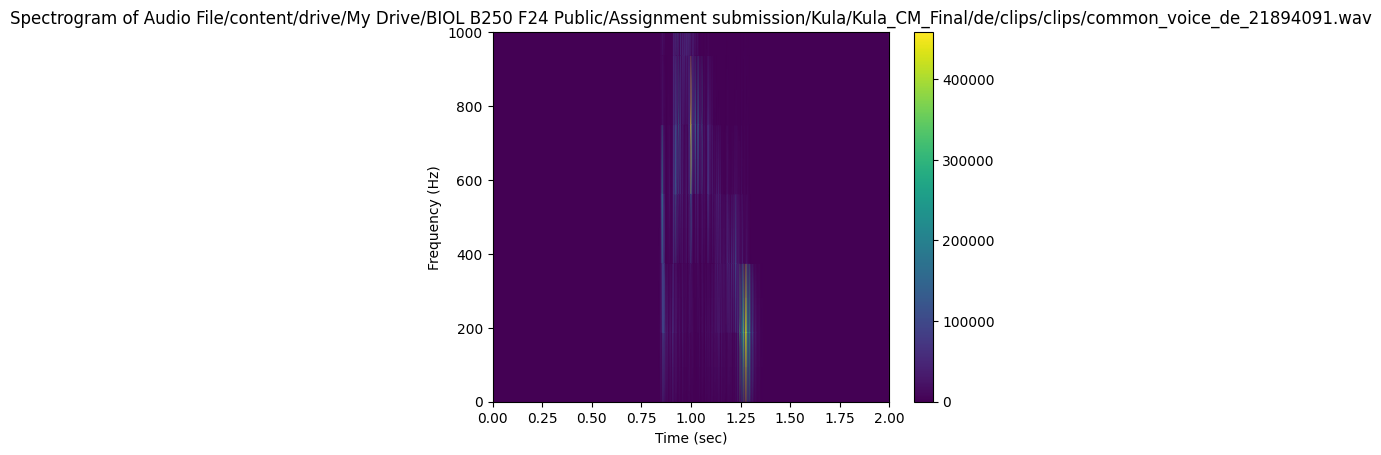

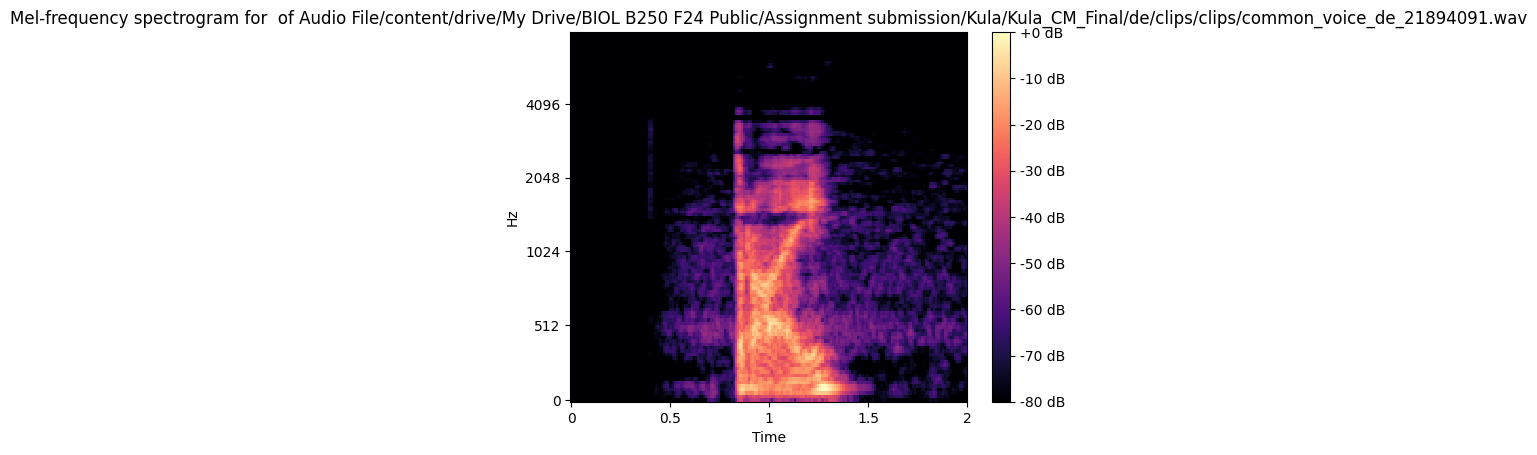

Audio duration: 2000 ms
Number of samples: 96000
Sampling frequency: 48000 Hz


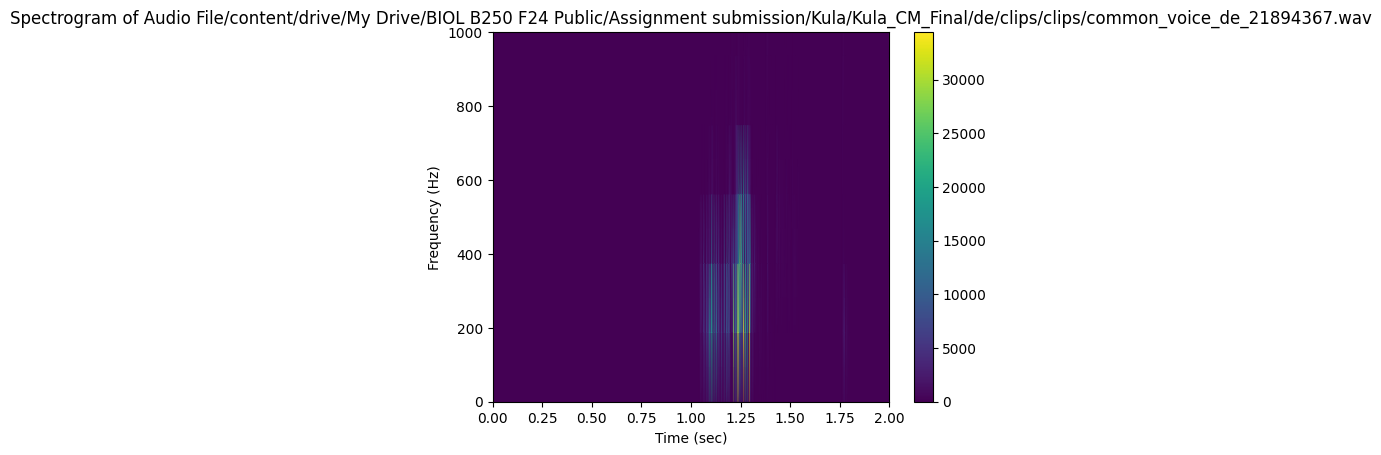

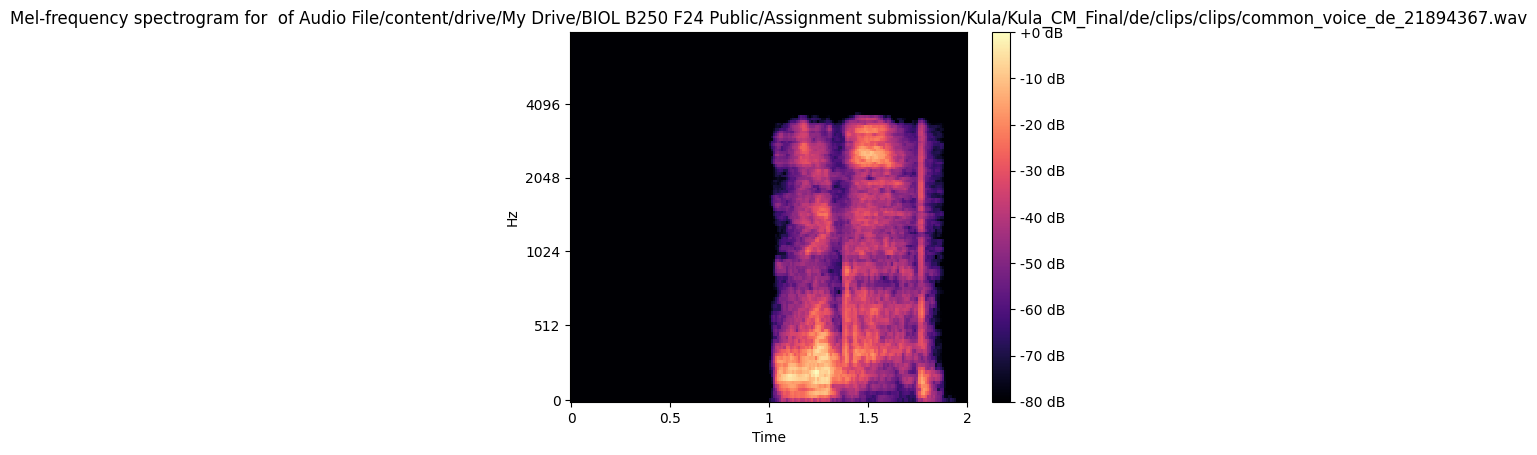

Audio duration: 2000 ms
Number of samples: 96000
Sampling frequency: 48000 Hz


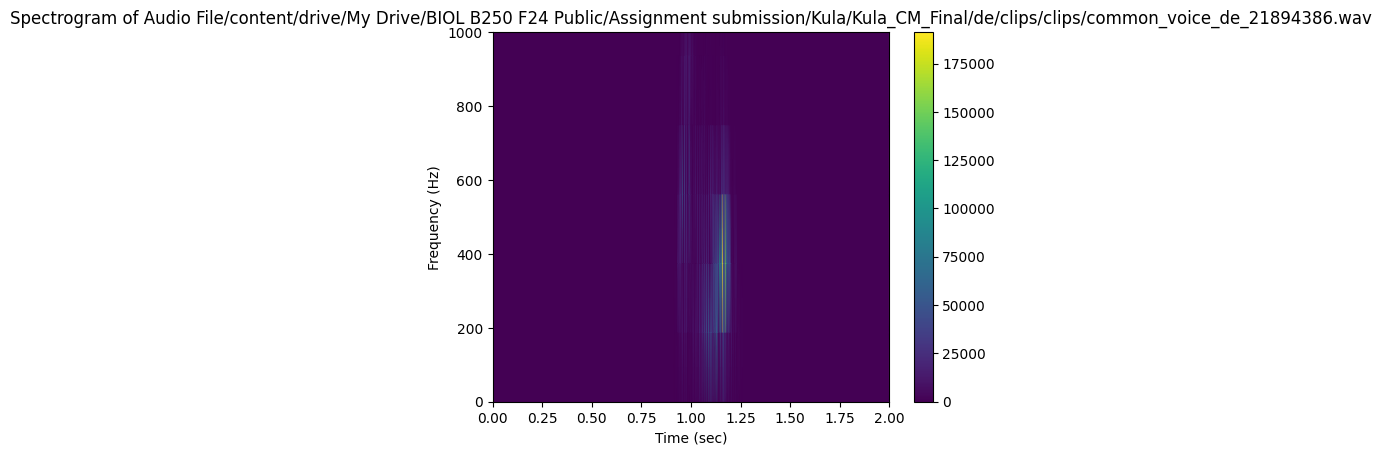

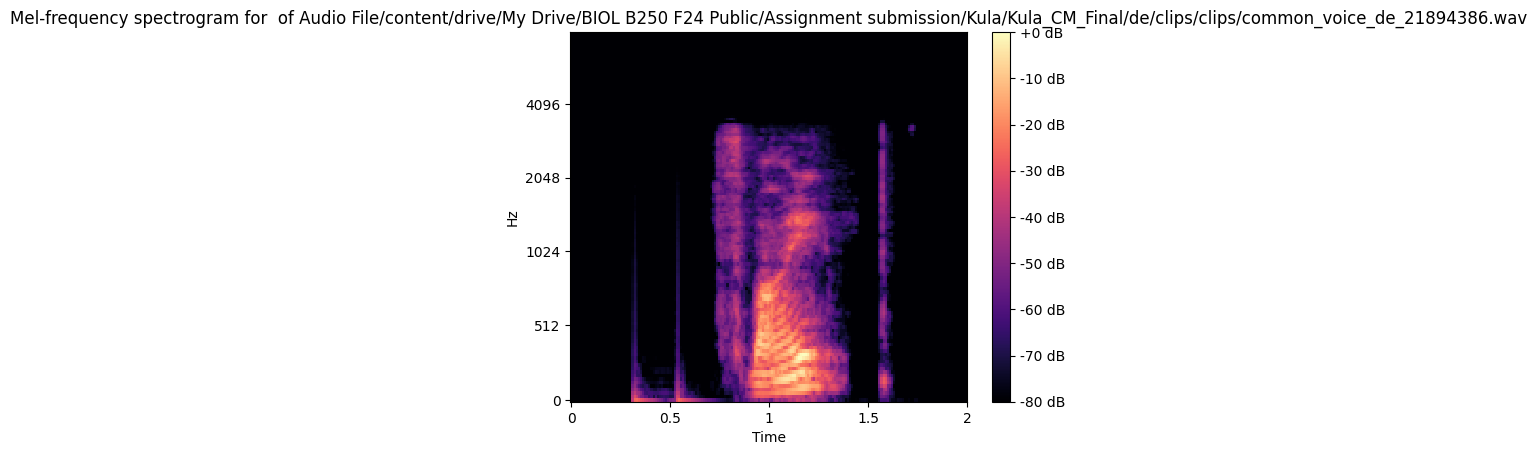

Audio duration: 2000 ms
Number of samples: 96000
Sampling frequency: 48000 Hz


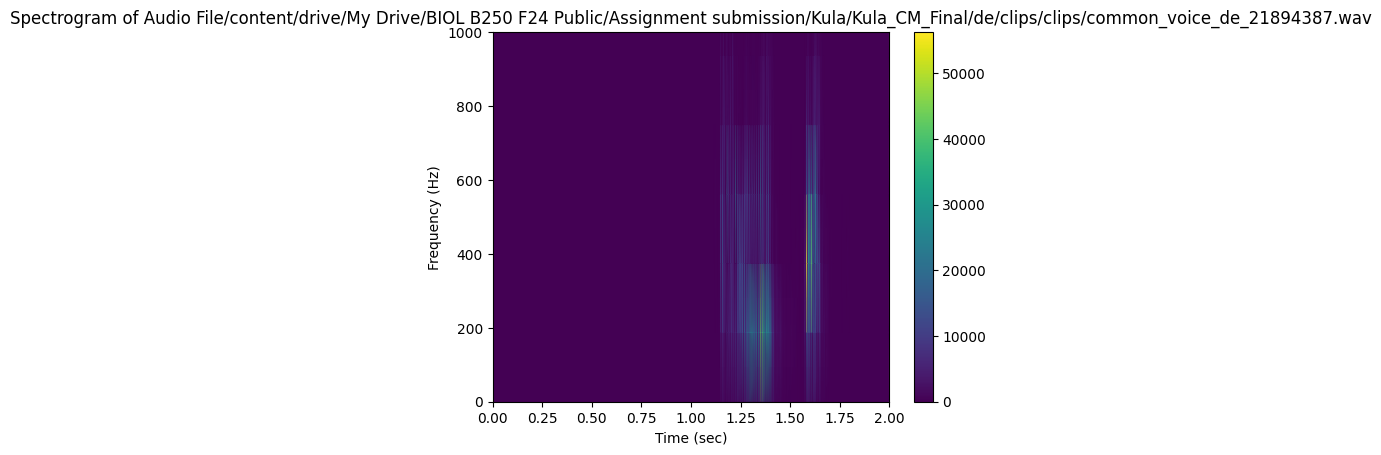

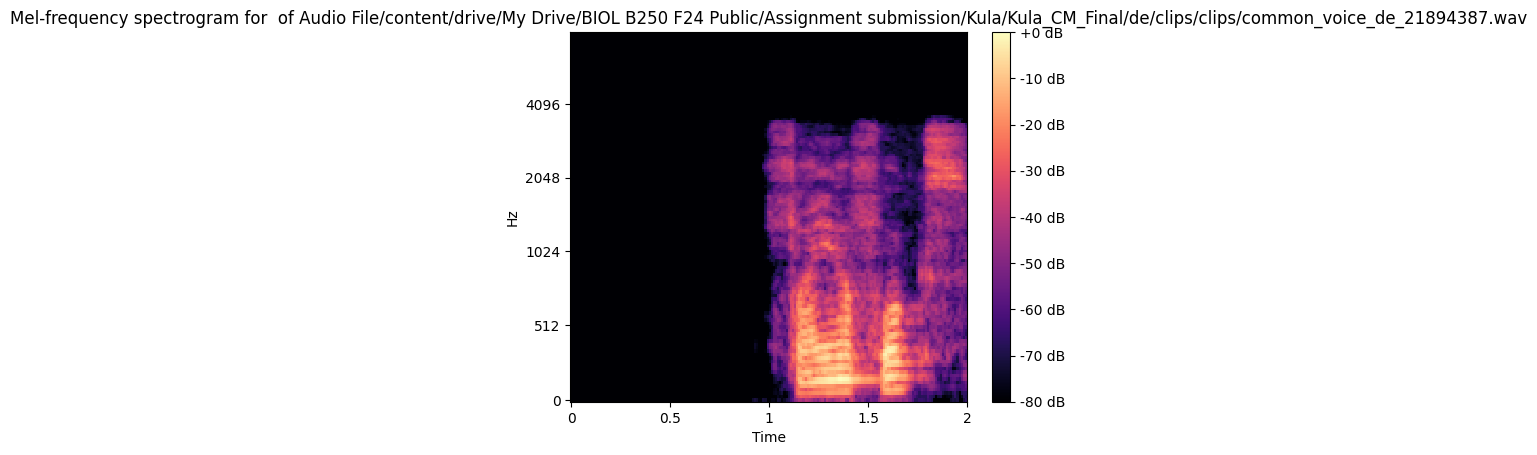

Audio duration: 2000 ms
Number of samples: 96000
Sampling frequency: 48000 Hz


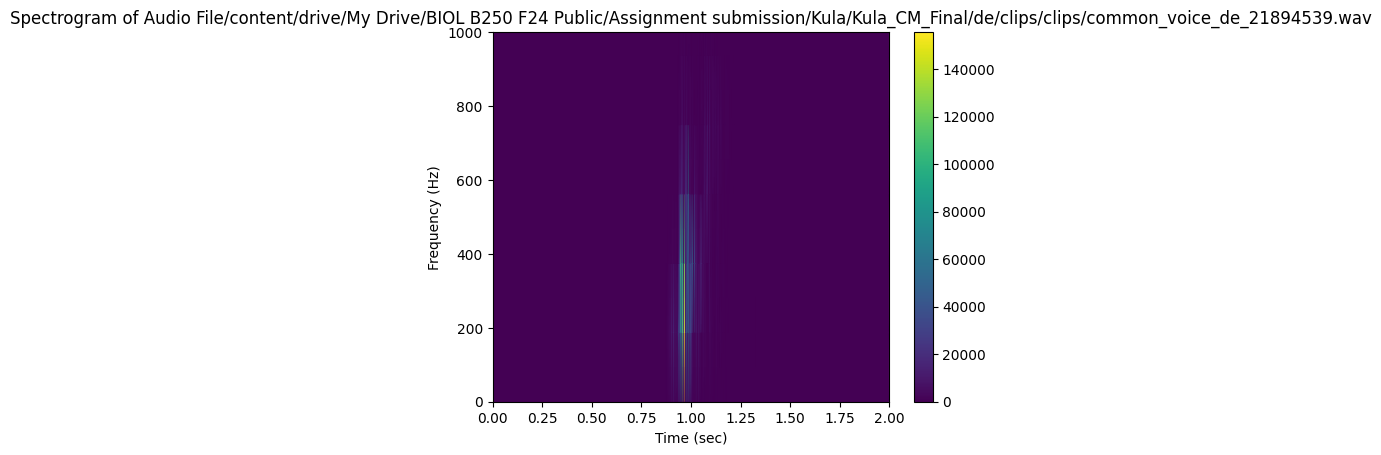

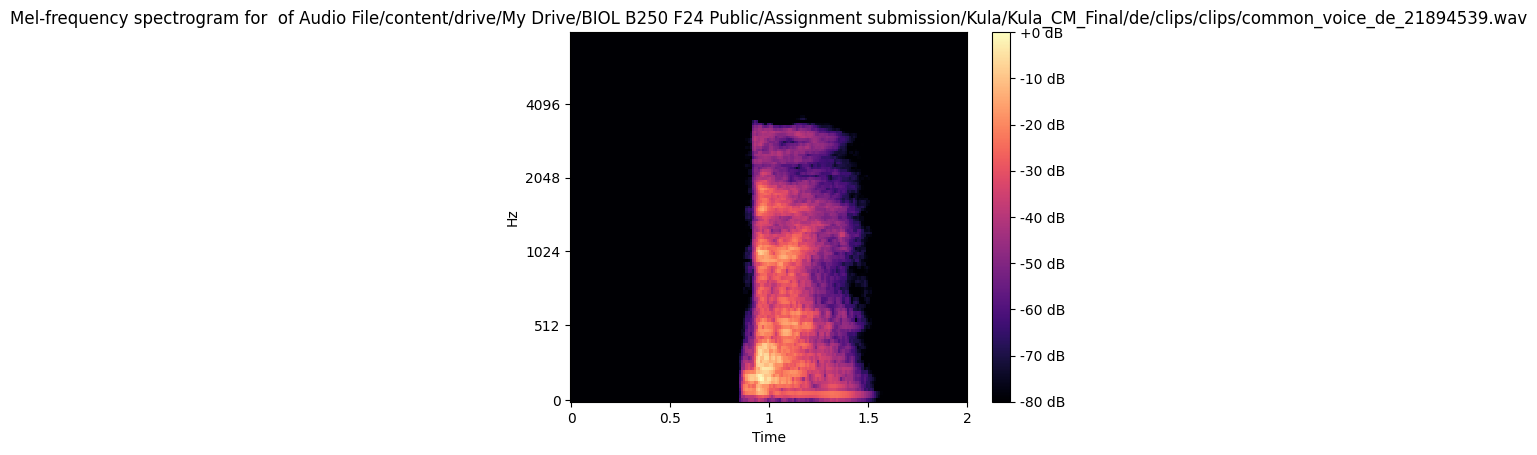

In [ ]:
folder = 'de' #Looks at German folder
folder_path = os.path.join(path_to_datasets, folder, 'clips/clips')  #Updates path (into clips/clips, since we created new folder clips)
wav_files = sorted(glob.glob(os.path.join(folder_path, '*.wav')))  #Creates a sorted list of the wav_files

for i in range(5): #Prints 5 images of each
  if wav_files: #Checks to make sure its not an empty list
      first_wav_file = wav_files[i]  # Get the i-th .wav file(here we plot 5)

      #Loads the files using pydub
      try:
          audio = AudioSegment.from_wav(first_wav_file) #Loads in audio files, creates AudioSegment object with the file
          print(f"Audio duration: {len(audio)} ms")
      except Exception as e: #Prints exception if error converting it to AudioSegment object
          print(f"Error loading audio: {e}")
          audio = None

      if audio:
          #If the audio file exists, we will create an array of the information and then plot it on the spectrogram.
          samples = np.array(audio.get_array_of_samples()) #Creates an array of audio information using built in pydub function
          print(f"Number of samples: {len(samples)}") # Prints number of samples for the audio file.

          sampFreq = audio.frame_rate  # Uses built in function audio.frame rate to find frequency
          print(f"Sampling frequency: {sampFreq} Hz")  # Prints sampling frequency that we found.


          f, t, Sxx = signal.spectrogram(samples, sampFreq) #Calculates the spectrogram

          # Plot the spectrogram using code from class
          plt.pcolormesh(t, f, Sxx, shading='gouraud') #Plots the spectrogram
          plt.ylabel('Frequency (Hz)') #Plots y label
          plt.xlabel('Time (sec)') #Plots x label
          plt.ylim([0, 1000]) #Limits y axis
          plt.xlim([0,2]) #Limits x axis to 2 seconds
          plt.colorbar() #Creates a color bar of amplitude
          plt.title("Spectrogram of Audio File" + str(first_wav_file)) #Creates title
          plt.show()

          #GPT to help normalize samples for input into spectrogram
          samples = samples.astype(float) # pydub samples are in integer format, this converts them to float
          samples = samples / (2**15)  #Normalizes the array to float values between -1 and 1 for librosa

          #Plot mel spectogram using GPT and https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
          # and https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html

          # Generate the Mel spectrogram
          n_fft = 2048 #Uses 2048 samples for each fft(window for each fft, but overall is stft)
          S = librosa.feature.melspectrogram(y=samples, sr=sampFreq, n_fft = n_fft) #https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
          fig, ax = plt.subplots()
          S_dB = librosa.power_to_db(S, ref=np.max)# Convert to decibals
          img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampFreq, fmax=8000, ax=ax) #Plots spectrogram. 8000 hz is typcal max for human voice
          plt.colorbar(img, ax=ax, format='%+2.0f dB')# Add a color bar to the plot
          plt.title('Mel-frequency spectrogram for  of Audio File' + str(first_wav_file))
          plt.show()
  else:
      print("No .wav files found in the specified folder.")

## Conversion of Audio file to Mel Spectrogram to NP array

We first define two functions: one to convert the audio segments into mel spectrograms by one file(convert_to_mel_spectrogram), and the other that iterates over the dataframe and dynamically pads the spectrograms by calling the first function(process_audio_files_from_df). By calling the second function, we call the first function and output a numpy array. Much of this section was taken from above or help with GPT when dealing with padding issues, etc.

In [ ]:
#This function does very similar to above, but also repads to exactly 2 seconds again.
def convert_to_mel_spectrogram(audio_file_path, n_mels=128, target_length=2000): #Function to convert one file to mel spedtrograms. n_mels = 128 controls frequency resolution. Will be a final dim of output
    try: #help from GPT to catch errors without completely stopping code
        audio = AudioSegment.from_file(audio_file_path)

        # Confirms length is exactly 2 seconds(errors if not). Pads again if not.
        current_length = len(audio)
        if current_length < target_length:
            audio += AudioSegment.silent(duration=(target_length - current_length))
        elif current_length > target_length:
            audio = audio[:target_length]

        samples = np.array(audio.get_array_of_samples())#Creates an array for the samples

        samples = samples.astype(np.float32) / (2**15)# Normalize the sample array to float values between -1 and 1 for librosa

        sampFreq = audio.frame_rate#Finds sampling frequency using frame_rate, which is a built in pydub function https://www.geeksforgeeks.org/working-with-wav-files-in-python-using-pydub/

        #Calls mel spectrogram
        S = librosa.feature.melspectrogram(y=samples, sr=sampFreq, n_mels=n_mels) #Input into librosa is audio samples for 1 file, the sampling frequnecy calculated using .frame_rate
        S_dB = librosa.power_to_db(S, ref=np.max)# Convert to decibals(This takes the place of amplitute on a regular spectrogram)

        #Converts time to frames and then pads if needed.
        expected_frames = librosa.time_to_frames(target_length / 1000, sr=sampFreq) #Converts time value to frames
        if S_dB.shape[1] < expected_frames:# Pads for correct number of frames: Uses GPT
            S_dB = np.pad(S_dB, ((0, 0), (0, expected_frames - S_dB.shape[1])), 'constant', constant_values=-80) #Value of -80 is typical of mel spectrogram(silence)
        return S_dB

    except Exception as e: #prints exception if theres an error
        print(f"Error processing {audio_file_path}: {e}")
        return None

def process_audio_files_from_df(df, folder_path, n_mels=128, target_length=2000):#Processes all audio files. Much of the function was generated through GPT.
    #Calculates max expected frames for uniform spectrogram size(so all spectrograms are of same size)
    max_frames = None #Sets max frames to none(start with no max)
    spectrograms = [] #Empty list to store spectrograms

    for index, row in df.iterrows(): #Iterates across the dataframe
        file_path = os.path.join(folder_path, row['path']) #Grabs one audio file
        print(f"Processing file: {file_path}")
        spectrogram = convert_to_mel_spectrogram(file_path, n_mels, target_length) # Calls above function on the single audio file
        if spectrogram is not None: #If there are already spectrograms in the list, make this spectrogram the same size as that
            if max_frames is None:
                max_frames = spectrogram.shape[1]
            elif spectrogram.shape[1] > max_frames: #If there are no spectrograms in the list, we use the first as model for the rest.
                max_frames = spectrogram.shape[1]

            spectrograms.append(spectrogram) #Adds spectrogram to list of spectrograms

    #Again, insures all spectrograms have the same width. Generated with GPT. This pads spectrograms if necessary. (Padding should not be added in rows(0,0) but in columns until max_frames size)
    spectrograms = [np.pad(spec, ((0, 0), (0, max_frames - spec.shape[1])), 'constant', constant_values=-80) if spec.shape[1] < max_frames else spec for spec in spectrograms]

    return np.array(spectrograms)


#German File Processing

We will now process the German Files.

First, we call the above functions on our German audio files. We define the path to access the drive folder and only want the fields listed in the balanced dataframes.

In [ ]:

#Defines path and processes data
folder = 'de'
folder_path = os.path.join(path_to_datasets, folder, 'clips/clips')

# Runs audio files through above functions.
train_de_spectrograms = process_audio_files_from_df(balanced_de_train, folder_path)
test_de_spectrograms = process_audio_files_from_df(balanced_de_test, folder_path)

print("Finished processing all files.")



Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/common_voice_de_21958752.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/common_voice_de_22024045.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/common_voice_de_22004873.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/common_voice_de_22448786.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/common_voice_de_23891587.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/common_voice_de_21984228.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/de/clips/clips/

We then convert the data from arrays to torch tensors. We also print the shape to prepare for the next step.

In [ ]:

deDataTrain1 = torch.tensor(train_de_spectrograms, dtype=torch.float32) #Converts training data to tensor
print(np.shape(deDataTrain1)) #Prints shape of data training set

deDataTest1 = torch.tensor(test_de_spectrograms,dtype=torch.float32) #Converts testing data to tensor
print(np.shape(german_labels_train)) # Prints shape of labels




torch.Size([400, 128, 188])
torch.Size([400, 1])


Below prepares the dataset to be input to the model. First,we need to flatten the data from [200,128,188] to size [200, x], where x = 128*188. Then we yet again normalize the data.

In [ ]:
deDataTrain = torch.reshape(deDataTrain1, (deDataTrain1.size(0), -1)) # Flatten to [500, 128*188] #Used GPT to help reshape
deDataTest = torch.reshape(deDataTest1, (deDataTest1.size(0), -1))  # Flatten to [400, 128*188](aka [400,24064])

#Normalizes dataset as better input into model #Used GPT to normalize
deDataTrain = (deDataTrain - torch.mean(deDataTrain)) / torch.std(deDataTrain)
deDataTest = (deDataTest - torch.mean(deDataTest)) / torch.std(deDataTest)


## The Model -- German

This is the model we will use. This is largely adapted from our in class model. We use the BCEWithLogitsLoss function, which has the sigmoid function built in.

In [ ]:
#Creates Model
torch.manual_seed(12) #Sets seed to 12

modelAudio = nn.Sequential(  # nn.Sequential() stacks all of our neural network layers together.
                        #   inside nn.Sequential(), specify layers of the network: alternating linear layers,
                        #   which do matrix multiplication, and nonlinear layers, which implement the activation
                       #   function (ReLU in this case)
    nn.Linear(24064, 5092),     # linear layer that takes 60032 inputs and projects to 5092 nodes in the next layer(60032 measurements for each sample)
    nn.ReLU(),            # nonlinear ReLU for all nodes
    nn.Linear(5092, 1024),     # linear layer that takes 5092 inputs and projects to 1024 nodes in the next layer
    nn.ReLU(),            # nonlinear ReLU for all nodes
    nn.Linear(1024, 512),     # linear layer that takes 1024 inputs and projects to 512 nodes in the next layer
    nn.ReLU(),               # nonlinear ReLU for all nodes
    nn.Linear(512, 128),     # linear layer that takes 512 inputs and projects to 128 nodes in the next layer
    nn.ReLU(),              # nonlinear ReLU for all nodes
    nn.Linear(128, 8),      # linear layer that takes 128 inputs and projects to 8 node in the next layer
    nn.ReLU(),               # nonlinear ReLU for all nodes
    nn.Linear(8, 1),    # linear layer that takes 8 inputs and projects to 1 final outputs


)  # close nn.Sequential()

print(modelAudio) #Prints the model
loss_fn   = torch.nn.BCEWithLogitsLoss() #Defines loss function. This is good for binary classification
optimizer = optim.Adam(modelAudio.parameters(), lr=.00012)  # Adam (ADAptive Moment estimation) optimization algorithm -- a variant of gradient descent
                                                      # set learning rate ('lr') inside function

nIts = 10

#Creates empty numpy arrays in the shape of the number of iterations to save the iteration number, loss of training set, and loss of testing set.
iteration = np.zeros(nIts)
lossTrain = np.zeros(nIts)
lossTest = np.zeros(nIts)

for it in range(nIts):      # for each iteration of optimization
    y_pred = modelAudio(deDataTrain)          # predict model outputs based on current weights ('forward step')
    loss = loss_fn(y_pred, german_labels_train)  # calculate the loss, based on model current predictions (y_pred) and desired outputs
    lossTrain[it] = loss.detach().numpy() #Adds training loss to loss array, ensuring it is not a tensor
    iteration[it] = it         #Adds iteration to numpy array
    optimizer.zero_grad()      # reset all gradient values to 0
    loss.backward()            # calculate new gradient values for each weight based on current loss ('backward step')
    optimizer.step()           # update weights based on the optimization algorithm we chose above

    with torch.no_grad(): #Doesn't calculate grad for testing
        y_pred_test = modelAudio(deDataTest) #Runs model on testing
        loss_test = loss_fn(y_pred_test, german_labels_test) #Runs loss on test set
        lossTest[it] = loss_test.item() #Saves result of loss


    # Optionally, print the training and testing loss for monitoring from GPT recommendation on formatting
    if it % 2 == 0:
        print(f'Iteration {it}: Training Loss = {lossTrain[it]}, Testing Loss = {lossTest[it]}')


Sequential(
  (0): Linear(in_features=24064, out_features=5092, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5092, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=8, bias=True)
  (9): ReLU()
  (10): Linear(in_features=8, out_features=1, bias=True)
)
Iteration 0: Training Loss = 0.7099337577819824, Testing Loss = 0.7034143209457397
Iteration 2: Training Loss = 0.6845541596412659, Testing Loss = 0.6769481897354126
Iteration 4: Training Loss = 0.6435089707374573, Testing Loss = 0.6646954417228699
Iteration 6: Training Loss = 0.5941066145896912, Testing Loss = 0.6283265352249146
Iteration 8: Training Loss = 0.5550359487533569, Testing Loss = 0.6282247304916382


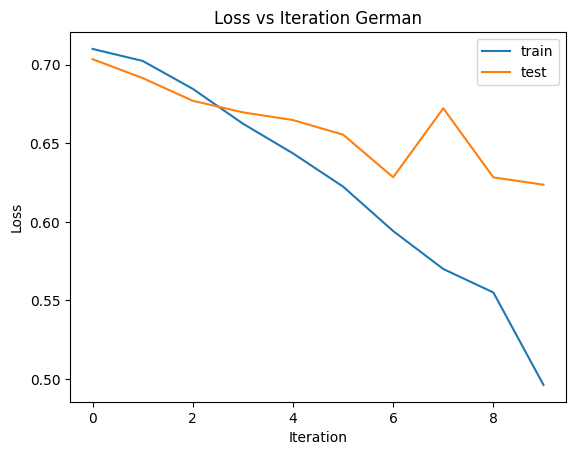

In [ ]:
#Plots loss vs iteration for German
plt.figure() #Creates figure
plt.plot(iteration, lossTrain, label = "train") #Plots training data
plt.plot(iteration, lossTest, label = 'test') #Plots testing data
plt.title("Loss vs Iteration German") #Creates title
plt.legend() #Creates legend
plt.xlabel("Iteration") #X axis label
plt.ylabel("Loss"); # Y axis label

Below is the function to calculate accuracy, which applies the sigmoid function to convert the logits output by the model to probabilities between 0 and 1.

In [ ]:
#Generated through a combination of GPT, classwork, and https://stackoverflow.com/questions/75979632/pytorchs-nn-bcewithlogitsloss-behaves-totaly-differently-than-nn-bceloss
def compute_accuracy(predictions, labels): #Computes the accuracy

    # Threshold predictions at 0.5 to determine class
    predicted_classes = (predictions > .5).float()
    correct = (predicted_classes == labels).float()  # Compares each element of predicted to the labels. Then finds the mean(overall accuracy)
    accuracy = correct.mean()  # Mean of correct predictions using
    return accuracy

#Runs model and calclates accuracy for German Data
y_pred_train = modelAudio(deDataTrain) #Runs model on training data
train_accuracy = compute_accuracy(y_pred_train, german_labels_train) #Calculates accuracy for German files
print(f"Train Accuracy: {train_accuracy:.4f}") #Prints accuracy for training set to 4 decimal places

with torch.no_grad():  # Ensure no gradients are computed during inference
  y_pred_test = modelAudio(deDataTest) #Same as above with test data
  test_accuracy = compute_accuracy(y_pred_test, german_labels_test)
  print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.7400
Test Accuracy: 0.6750


#English File Processing

The below section does the same as the German section, only with the English data.

In [ ]:
# Defines path for dataset. Here we are in the english folder
folder = 'en'
folder_path = os.path.join(path_to_datasets, folder, 'clips/clips')

# Converts df to mel spectrogram and then to numpy array
train_en_spectrograms = process_audio_files_from_df(balanced_en_train, folder_path)
test_en_spectrograms = process_audio_files_from_df(balanced_en_test, folder_path)

print("Finished processing all files.")

Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/common_voice_en_21915282.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/common_voice_en_22216351.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/common_voice_en_22263922.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/common_voice_en_22081160.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/common_voice_en_22219447.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/common_voice_en_22078734.wav
Processing file: /content/drive/My Drive/BIOL B250 F24 Public/Assignment submission/Kula/Kula_CM_Final/en/clips/clips/

In [ ]:
enDataTrain1 = torch.tensor(train_en_spectrograms, dtype=torch.float32) #Converts training data to tensor
print(np.shape(enDataTrain1)) #Prints shape of data training set
enDataTest1 = torch.tensor(test_en_spectrograms,dtype=torch.float32) #Converts testing data to tensor

print(np.shape(english_labels_train)) # Prints shape of labels


torch.Size([400, 128, 188])
torch.Size([400, 1])


Below prepares the dataset to be input to the model. First,we need to flatten the data from [200,128,188] to size [200, x], where x = 128*188. Then we yet again normalize the data.

In [ ]:
enDataTrain = torch.reshape(enDataTrain1, (enDataTrain1.size(0), -1)) # Flatten to [400, 128*188] #Used GPT to help reshape
enDataTest = torch.reshape(enDataTest1, (enDataTest1.size(0), -1))  # Flatten to [400, 128*188]

#Normalizes english data, simiar to German data
enDataTrain = (enDataTrain - torch.mean(enDataTrain)) / torch.std(enDataTrain)
enDataTest = (enDataTest - torch.mean(enDataTest)) / torch.std(enDataTest)


## The Model -- English

This is the model we will use. This is largely adapted from our in class model. We use the BCEWithLogitsLoss function, which has the sigmoid function built in. This is the same as the German model, only with the English data.

In [ ]:
#Creates Model
torch.manual_seed(12) #Sets seed to 12

modelAudio = nn.Sequential(  # nn.Sequential() stacks all of our neural network layers together.
                        #   inside nn.Sequential(), specify layers of the network: alternating linear layers,
                        #   which do matrix multiplication, and nonlinear layers, which implement the activation
                       #   function (ReLU in this case)
    nn.Linear(24064, 5092),     # linear layer that takes 60032 inputs and projects to 5092 nodes in the next layer(60032 measurements for each sample)
    nn.ReLU(),            # nonlinear ReLU for all nodes
    nn.Linear(5092, 1024),     # linear layer that takes 5092 inputs and projects to 1024 nodes in the next layer
    nn.ReLU(),            # nonlinear ReLU for all nodes
    nn.Linear(1024, 512),     # linear layer that takes 1024 inputs and projects to 512 nodes in the next layer
    nn.ReLU(),               # nonlinear ReLU for all nodes
    nn.Linear(512, 128),     # linear layer that takes 512 inputs and projects to 128 nodes in the next layer
    nn.ReLU(),              # nonlinear ReLU for all nodes
    nn.Linear(128, 8),      # linear layer that takes 128 inputs and projects to 8 node in the next layer
    nn.ReLU(),               # nonlinear ReLU for all nodes
    nn.Linear(8, 1),    # linear layer that takes 8 inputs and projects to 1 final outputs

)  # close nn.Sequential()

print(modelAudio) #Prints the model
loss_fn   = torch.nn.BCEWithLogitsLoss() #Defines loss function. This is good for binary classification
optimizer = optim.Adam(modelAudio.parameters(), lr=.00012)  # Adam (ADAptive Moment estimation) optimization algorithm -- a variant of gradient descent
                                                      # set learning rate ('lr') inside function

nIts = 10

#Creates empty numpy arrays in the shape of the number of iterations to save the iteration number, loss of training set, and loss of testing set.
iteration = np.zeros(nIts)
lossTrain = np.zeros(nIts)
lossTest = np.zeros(nIts)

for it in range(nIts):      # for each iteration of optimization
    y_pred = modelAudio(enDataTrain)          # predict model outputs based on current weights ('forward step')
    loss = loss_fn(y_pred, english_labels_train)  # calculate the loss, based on model current predictions (y_pred) and desired outputs
    lossTrain[it] = loss.detach().numpy() #Adds training loss to loss array, ensuring it is not a tensor
    iteration[it] = it         #Adds iteration to numpy array
    optimizer.zero_grad()      # reset all gradient values to 0
    loss.backward()            # calculate new gradient values for each weight based on current loss ('backward step')
    optimizer.step()           # update weights based on the optimization algorithm we chose above


    #modelAudio.eval()  #  Used GPT: Set the model to evaluation mode
    with torch.no_grad(): #Doesn't calculate grad for testing
        y_pred_test = modelAudio(enDataTest) #Runs model on testing
        loss_test = loss_fn(y_pred_test, english_labels_test) #Runs loss on test set
        lossTest[it] = loss_test.item() #Saves result of loss

    # Prints loss every 2 iterations
    if it % 2 == 0:
        print(f'Iteration {it}: Training Loss = {lossTrain[it]}, Testing Loss = {lossTest[it]}')

Sequential(
  (0): Linear(in_features=24064, out_features=5092, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5092, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=8, bias=True)
  (9): ReLU()
  (10): Linear(in_features=8, out_features=1, bias=True)
)
Iteration 0: Training Loss = 0.7099245190620422, Testing Loss = 0.7029565572738647
Iteration 2: Training Loss = 0.681841254234314, Testing Loss = 0.6738580465316772
Iteration 4: Training Loss = 0.6631186008453369, Testing Loss = 0.6657284498214722
Iteration 6: Training Loss = 0.6459282040596008, Testing Loss = 0.6627244353294373
Iteration 8: Training Loss = 0.6143336296081543, Testing Loss = 0.6582641005516052


Below is the Loss vs Iteration plot for English

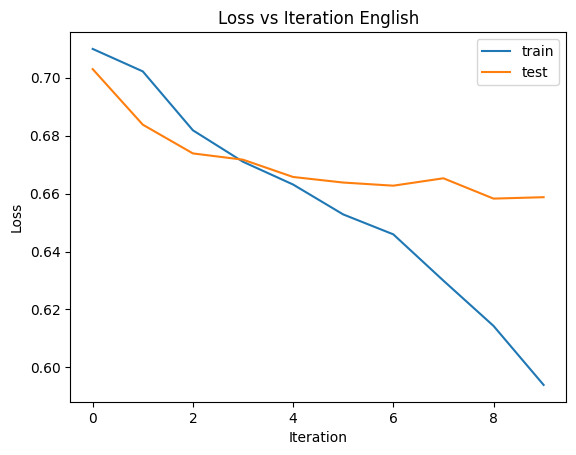

In [ ]:
#Plots loss vs iteration for English
plt.figure() #Creates figure
plt.plot(iteration, lossTrain, label = "train") #Plots training data
plt.plot(iteration, lossTest, label = 'test') #Plots testing data
plt.title("Loss vs Iteration English") #Creates title
plt.legend() #Creates legend
plt.xlabel("Iteration") #X axis label
plt.ylabel("Loss"); # Y axis label

Finally, here is the accuracy calculation, which calls the accuracy calculation function in the German section.

In [ ]:
y_pred_train = modelAudio(enDataTrain) #Runs model on training data
train_accuracy = compute_accuracy(y_pred_train, english_labels_train) #Calculates accuracy
print(f"Train Accuracy: {train_accuracy:.4f}") #Prints the accuracy in string form(instead of torch tensor)

with torch.no_grad():  # No gradients calculated during testing
  y_pred_test = modelAudio(enDataTest) #Runs model on test data
  test_accuracy = compute_accuracy(y_pred_test, english_labels_test) #Calls accuracy function
  print(f"Test Accuracy: {test_accuracy:.4f}") #Prints the accuracy in string form(instead of torch tensor)


Train Accuracy: 0.6400
Test Accuracy: 0.5750


# Results

Better than chance, but not by a lot. Best ran case: .00012. German is consistantly more accurate than English(Exception = .001, .008)


Learning Rate = .0001
*  German Data: Train Accuracy: 0.7125
Test Accuracy: 0.65
*   English Data: Train Accuracy: 0.6475
Test Accuracy: 0.5625





Learning Rate = .001
*  German Data: Train Accuracy: 0.615
Test Accuracy: 0.55
*   English Data: Train Accuracy: 0.59
Test Accuracy: 0.5625




Learning Rate = .008
*  German Data: Train Accuracy: 0.5
Test Accuracy: 0.5
*   English Data: Train Accuracy: 0.5
Test Accuracy: 0.5
(Seemed incorrect but tried with other learning rates and it produced other values, thus accuracy is just .5 with .008)


Learning Rate = .00012


*   German Data: Train Accuracy: 0.740 Test Accuracy: 0.6725
*   English Data: Train Accuracy: 0.64 Test Accuracy: 0.575




#Reflecting Questions:

What does this project demonstrate?


*   Difference in language accuracy
*   We can use simple NN model(instead of CNN)



What did I change to fix the big error?  normalized yet again, passed another

*   Normalized again
*   Passed another parameter into spectrogram
*   Fixed a padding error(was 5 seconds in 1 function where it should have been 2)
*   Reran model from top to finish. If I did not restart session and ran model again, got .5 accuracy. Restarting session solves this issue. Also learning rate of .008 gives .5 accuracy. Running on another lr confirmed this.

How did I convince myself my code was working properly?

1.   Accuracy was exactly .5 -- Seemed off. When this changed and my loss function decreased- good sign!
2.   Looked more closely at previous implimentations and confirmed my functions closely matched theirs.



What was the hardest part of this project?

1.   Solving the consistant accuracy error problem
2.   Preprocessing the data and confirming padding, dimensions, timing was correct.



What would I do differently?

1.   Work with 1 language first
2.   Closely followed what is input into Mel Spectrogram



What steps would I take with more time?


1.   Try a better model(More iterations, data, learning rate, CNN) or loss function.
2.   Impliment this on other languages, including other genders(other) with multiclass, longer phrases, or segments with multiple speakers.



What libraries did I use and what are the important features?

Important libraries used:


*  Librosa - Mel Spectrograms. Important functions: # Passing through arguments to the Mel filters S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000) , S_dB = librosa.power_to_db(S, ref=np.max)
*   Pandas: Great for processing dataframes
*   Pydub: Audio processing with .frame_rate, .get_array_with_samples



Loss function:
BCE Loss: Applies sigmoid to model output(turns output(logits) into probabilities) and then measures distance between true labels and probability. This is the mathematical process, but in reality, are done at the same time.